In [14]:
## Imports ##
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import random
import matplotlib.pyplot as plt
from tensorflow.keras import Model, backend as keras_backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, concatenate, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16
from itertools import product
from tensorflow.keras.callbacks import EarlyStopping



# 1. Prepare the dataset

In [2]:
def load_dataset(directory, target_size=(256, 256)):
    images = []
    labels = []
    daffodil_indices = range(1, 81)
    dandelion_indices = range(961, 1041)
    sunflower_indices = range(721, 801)

    for filename in os.listdir(directory):
        if filename.startswith("image_"):
            image_num = int(filename.split("_")[1].split(".")[0])

            # Assign label based on image number
            if image_num in daffodil_indices:
                label = 0
            elif image_num in dandelion_indices:
                label = 1
            elif image_num in sunflower_indices:
                label = 2
            else:
                continue  # Skip images not in the specified ranges

            # Load and preprocess image
            image_path = os.path.join(directory, filename)
            image = load_img(image_path, target_size=target_size)
            image = img_to_array(image) / 255.0

            # Append data to lists
            images.append(image)
            labels.append(label)

    return np.array(images), np.array(labels)
# To ensure successful load of the image dataset, please adjust the path to the 17flowers folder

images, labels = load_dataset('17flowers')


In [3]:
print(images.shape)
print(labels.shape)

(240, 256, 256, 3)
(240,)


In [4]:
def display_random_images(images, labels, label_map, num_images=2):
    random_indices = random.sample(range(len(images)), num_images)
    plt.figure(figsize=(10, 5))

    for i, idx in enumerate(random_indices):
        plt.subplot(1, num_images, i + 1)
        label = label_map[labels[idx]]  # Convert numerical label to flower name
        plt.imshow(images[idx])
        plt.title(f"Label: {label}")
        plt.axis("off")
    
    plt.show()

In [5]:
label_map = {0: 'daffodil', 1: 'dandelion', 2: 'sunflower'}


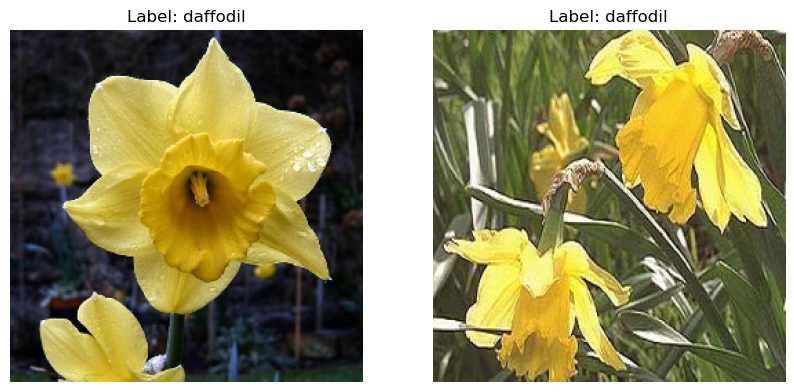

In [6]:
display_random_images(images, labels, label_map)

# 2. Define a reusable class to build a model

In [42]:
class CNNModel:
    def __init__(self):
        self.model_output = None
        self.model_input = None
        self.is_sequential = None
        self.evaluation_results = None
        self.model = None
        self.history = None
        
    def create_model(self, model_type='sequential', input_shape=(256, 256, 3)):
        if model_type == 'sequential':
            self.model = Sequential()
            self.is_sequential = True
        elif model_type == 'vgg16':
            vgg16_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
            for layer in vgg16_model.layers:
                layer.trainable = False
            self.model = Sequential()
            self.model.add(vgg16_model)
            self.is_sequential = True
        elif model_type == 'functional':
            self.model_input = Input(shape=input_shape)
            self.model_output = self.model_input
            self.is_sequential = False
        else:
            raise ValueError(f"Unknown model type: {model_type}")
        return self
    
    def add_layer(self, layer):
        if self.is_sequential:
            self.model.add(layer)
        else:
            self.model_output = layer(self.model_output)
        return self
        
    def add_conv2d(self, number_of_filters=16, kernel_size=(3, 3), activation='relu', regularizer=None):
        return self.add_layer(Conv2D(number_of_filters, kernel_size, activation=activation, kernel_regularizer=regularizer))

    def add_maxpooling2d(self, pool_size=(2, 2)):
        return self.add_layer(MaxPooling2D(pool_size=pool_size))

    def add_flatten(self):
        return self.add_layer(Flatten())

    def add_dense(self, number_of_neurons=3, activation='softmax', regularizer=None):
        return self.add_layer(Dense(number_of_neurons, activation=activation, kernel_regularizer=regularizer))

    def add_dropout(self, rate):
        return self.add_layer(Dropout(rate))

    
    def add_inception_module(self, filter_channels):
        if self.is_sequential:
            raise ValueError("Inception module can only be added to a functional model")

        # Inception module implementation
        conv1 = Conv2D(filter_channels[0], (1, 1), padding='same', activation='relu')(self.model_output)
        conv3 = Conv2D(filter_channels[1], (3, 3), padding='same', activation='relu')(self.model_output)
        conv5 = Conv2D(filter_channels[2], (5, 5), padding='same', activation='relu')(self.model_output)
        pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(self.model_output)
        self.model_output = concatenate([conv1, conv3, conv5, pool], axis=-1)
        return self

    def build(self):
        if not self.is_sequential:
            self.model = Model(inputs=self.model_input, outputs=self.model_output)
        return self
    
    def predict(self, images):
        return self.model.predict(images)
    
    def train(self, train_images, train_labels_one_hot, val_images, val_labels_one_hot, 
              epochs=20, batch_size=14, learning_rate=2e-5, early_stopping_monitor='val_loss', 
              early_stopping_patience=6, restore_best_weights=True):
        self.model.compile(optimizer=RMSprop(learning_rate=learning_rate), 
                           loss='categorical_crossentropy', 
                           metrics=['accuracy'])
        
        # Early Stopping callback
        early_stopping_callback = EarlyStopping(monitor=early_stopping_monitor,
                                                patience=early_stopping_patience,
                                                restore_best_weights=restore_best_weights,
                                                verbose=1)

        steps_per_epoch = len(train_images) // batch_size
        validation_steps = len(val_images) // batch_size
       
        self.history = self.model.fit(
            train_images, train_labels_one_hot,
            epochs=epochs,
            batch_size=batch_size,
            steps_per_epoch=steps_per_epoch,
            validation_data=(val_images, val_labels_one_hot),
            validation_steps=validation_steps,
            callbacks=[early_stopping_callback]
        )
        return self

    def train_with_augmentation(self, 
                                train_images, train_labels, val_images, val_labels, 
                                epochs, batch_size, learning_rate, 
                                augment_params, 
                                early_stopping_monitor='val_loss', 
                                early_stopping_patience=6, 
                                restore_best_weights=True):
        
        self.model.compile(optimizer=RMSprop(learning_rate=learning_rate), 
                           loss='categorical_crossentropy', 
                           metrics=['accuracy'])

        # Set up data augmentation
        datagen = ImageDataGenerator(**augment_params)
        train_generator = datagen.flow(train_images, train_labels, batch_size=batch_size)

        # Early Stopping callback
        early_stopping_callback = EarlyStopping(monitor=early_stopping_monitor,
                                                patience=early_stopping_patience,
                                                restore_best_weights=restore_best_weights,
                                                verbose=1)

        steps_per_epoch = len(train_images) // batch_size
        validation_steps = len(val_images) // batch_size

        self.history = self.model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            validation_data=(val_images, val_labels),
            validation_steps=validation_steps,
            callbacks=[early_stopping_callback]
        )
        return self

    def evaluate_model(self, test_images, test_labels_one_hot, val_images, val_labels_one_hot):
        print("Evaluation results:")
        test_loss, test_acc = self.model.evaluate(test_images, test_labels_one_hot, verbose=2)
        val_loss, val_acc = self.model.evaluate(val_images, val_labels_one_hot, verbose=2)
        
        print(f"Test Loss: {test_loss:.8f}, Test Accuracy: {test_acc:.8f}")
        print(f"Validation Loss: {val_loss:.8f}, Validation Accuracy: {val_acc:.8f}")
        
        self.evaluation_results = {
            'test_loss': test_loss,
            'test_acc': test_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        }
        
        return self

    def summary(self):
        self.model.summary()
        return self
    

# 3. Model Evaluation
#### To test the models, we will introduce a Model Evaluator class. Its purpose is the ability to perform k-fold cross validation, test different hyperparameters, and plot the results.


In [60]:
class ModelEvaluator:
    def __init__(self, images, labels):
        self.hyperparam_results = None
        self.images = images
        self.labels = labels
        self.fold_metrics = []
        self.best_result = None
        self.single_run_result = None
        self.current_config = {}
        self.current_model_name = ""
        self.results_averages = {}

    def set_params(self, epochs, batch_size, learning_rate):
        self.current_config = {
            'epochs': epochs,
            'batch_size': batch_size,
            'learning_rate': learning_rate
        }
        return self

    def run_single_experiment(self, create_model_func, model_name, use_augmentation=False, augment_params=None, visualise_feature_maps=False):
        self.current_model_name = model_name
        # Split the dataset into training, validation, and testing sets
        (train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = self.split_data(0.7, 0.15, 0.15)
        train_labels_one_hot = to_categorical(train_labels, num_classes=3)
        val_labels_one_hot = to_categorical(val_labels, num_classes=3)
        test_labels_one_hot = to_categorical(test_labels, num_classes=3)
        
        
        # Create and train the model
        model_instance = create_model_func()
        if use_augmentation and augment_params:
            model_instance.train_with_augmentation(train_images, train_labels_one_hot, val_images, val_labels_one_hot, self.current_config['epochs'], self.current_config['batch_size'], self.current_config['learning_rate'], augment_params)
        else:
            model_instance.train(train_images, train_labels_one_hot, val_images, val_labels_one_hot, self.current_config['epochs'], self.current_config['batch_size'], self.current_config['learning_rate'])
        
        # Evaluate the model
        model_instance.evaluate_model(test_images, test_labels_one_hot, val_images, val_labels_one_hot)
        
        if visualise_feature_maps:
            self.visualise_feature_maps(model_instance, test_images[:1], layer_type='conv')
        # Ensure history is being captured
        model_instance.evaluate_model(test_images, test_labels_one_hot, val_images, val_labels_one_hot)
        self.single_run_result = model_instance.evaluation_results
        self.single_run_result['history'] = model_instance.history.history if model_instance.history else None
        return self


    def perform_kfold_validation(self, create_model_func, model_name, num_splits=4, use_augmentation=False, augment_params=None):
        self.current_model_name = model_name
        # Split the dataset into training, validation, and testing sets
        (dev_images, dev_labels), (_, _), (test_images, test_labels) = self.split_data(0.85, 0.0, 0.15)
        test_labels_one_hot = to_categorical(test_labels, num_classes=3)
        dev_labels_one_hot = to_categorical(dev_labels, num_classes=3)
    
        kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)
    
        for train_index, val_index in kf.split(dev_images):
            X_train, X_val = dev_images[train_index], dev_images[val_index]
            y_train, y_val = dev_labels_one_hot[train_index], dev_labels_one_hot[val_index]
    
            # Create a new model instance for each fold
            model_instance = create_model_func()
    
            if use_augmentation and augment_params:
                model_instance.train_with_augmentation(X_train, y_train, X_val, y_val, self.current_config['epochs'], self.current_config['batch_size'], self.current_config['learning_rate'], augment_params)
            else:
                model_instance.train(X_train, y_train, X_val, y_val, self.current_config['epochs'], self.current_config['batch_size'], self.current_config['learning_rate'])
            model_instance.summary()

            model_instance.evaluate_model(test_images, test_labels_one_hot, X_val, y_val)
            metrics = model_instance.evaluation_results
            metrics['history'] = model_instance.history.history if model_instance.history else None
            self.fold_metrics.append(metrics)
        
        self.select_best_model()
        self.results_averages = {
            'avg_val_acc': np.mean([m['val_acc'] for m in self.fold_metrics]),
            'avg_val_loss': np.mean([m['val_loss'] for m in self.fold_metrics]),
            'avg_test_acc': np.mean([m['test_acc'] for m in self.fold_metrics]),
            'avg_test_loss': np.mean([m['test_loss'] for m in self.fold_metrics])
        }
        return self

    
    def test_hyperparameters(self, create_model_func, model_name, hyperparams, use_augmentation=False, augment_params=None):
        self.current_model_name = model_name
        self.hyperparam_results = []  # Reset or initialize the results list
    
        # Generate all combinations of hyperparameters
        keys, values = zip(*hyperparams.items())
        for combination in product(*values):
            params = dict(zip(keys, combination))
            print(f"Testing with parameters: {params}")
    
            # Set current training hyperparameters
            self.set_params(**{k: params[k] for k in ['epochs', 'batch_size', 'learning_rate']})
    
            try:
                # Perform single-run validation
                results = self.run_single_experiment(lambda: create_model_func(**{k: params[k] for k in params if k not in ['epochs', 'batch_size', 'learning_rate']}), model_name, use_augmentation, augment_params).single_run_result
    
                # Store results including history for plotting
                minimal_results = {
                    'params': params,
                    'val_acc': results.get('val_acc'),
                    'test_acc': results.get('test_acc'),
                    'test_loss': results.get('test_loss'),
                    'val_loss': results.get('val_loss'),
                    'history': results.get('history')  # Storing history for the best model's detailed graphs
                }
                self.hyperparam_results.append(minimal_results)
            except Exception as e:
                print(f"Error encountered while testing parameters {params}: {e}")
    
        # Select the best overall result based on a balance of validation accuracy and test accuracy
        best_overall_index = np.argmax([r['val_acc'] + r['test_acc'] for r in self.hyperparam_results])  # Consider both val and test accuracy
        self.best_result = self.hyperparam_results[best_overall_index]
        return self


    def get_hyperparam_results(self):
        return self.hyperparam_results

    def select_best_model(self):
        best_fold_index = np.argmax([m['val_acc'] for m in self.fold_metrics])
        self.best_result = self.fold_metrics[best_fold_index]
        return self

    def plot_results(self):
        # Check if it's a single run experiment and plot the history
        if self.single_run_result and 'history' in self.single_run_result:
            self.plot_detailed_history(self.single_run_result['history'], f"{self.current_model_name} - \nSingle Experiment Detailed History")
        
        # Plot summary of k-fold accuracies
        if self.fold_metrics:
            self.plot_kfold_metrics(self.fold_metrics, f"{self.current_model_name} - \nK-Fold Validation Results")
        
        # Plot detailed history of the best model
        if self.best_result and 'history' in self.best_result:
            self.plot_detailed_history(self.best_result['history'], f"{self.current_model_name} - \nBest Model Detailed History")

        return self

    
    def plot_detailed_history(self, history, title):
        if 'accuracy' in history and 'val_accuracy' in history:
            acc = history['accuracy']
            val_acc = history['val_accuracy']
            epochs_range = range(1, len(acc) + 1)
    
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.plot(epochs_range, acc, label='Training Accuracy')
            plt.plot(epochs_range, val_acc, label='Validation Accuracy')
            plt.title(f'Training and Validation Accuracy\n{title}')
            plt.legend()
    
        if 'loss' in history and 'val_loss' in history:
            loss = history['loss']
            val_loss = history['val_loss']
    
            plt.subplot(1, 2, 2)
            plt.plot(epochs_range, loss, label='Training Loss')
            plt.plot(epochs_range, val_loss, label='Validation Loss')
            plt.title(f'Training and Validation Loss\n{title}')
            plt.legend()
    
            plt.tight_layout()
            plt.show()
        else:
            print("History data not available for plotting")
        return self

    
    def plot_kfold_metrics(self, fold_metrics, model_name):
        num_splits = len(fold_metrics)
    
        # Print average results from folds
        print(f"\nModel: {model_name}")
        avg_val_acc = self.results_averages['avg_val_acc']
        avg_val_loss = self.results_averages['avg_val_loss']
        avg_test_acc = self.results_averages['avg_test_acc']
        avg_test_loss = self.results_averages['avg_test_loss']
        print("Average Validation Results:")
        print(f"Average Validation Accuracy: {avg_val_acc:.4f}, Average Validation Loss: {avg_val_loss:.4f}")
        print("Average Test Results:")
        print(f"Average Test Accuracy: {avg_test_acc:.4f}, Average Test Loss: {avg_test_loss:.4f}")
    
        # Plotting results
        val_accuracies = [m['val_acc'] for m in fold_metrics]
        test_accuracies = [m['test_acc'] for m in fold_metrics]
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, num_splits + 1), val_accuracies, label='Validation Accuracy per Fold', marker='o')
        plt.plot(range(1, num_splits + 1), test_accuracies, label='Test Accuracy per Fold', marker='o')
        plt.xlabel('Fold Number')
        plt.ylabel('Accuracy')
        plt.title(f'Validation and Test Accuracy per Fold - {model_name}')
        plt.legend()
        plt.show()
        
        # Find the best performing fold
        best_fold_index = np.argmax([m['val_acc'] for m in fold_metrics])
        best_fold_history = fold_metrics[best_fold_index]['history']
        best_fold_test_acc = fold_metrics[best_fold_index]['test_acc']
        best_fold_val_acc = fold_metrics[best_fold_index]['val_acc']
    
        # Display the best fold's test and validation accuracy
        print(f"\nBest Fold ({best_fold_index + 1}) Performance:")
        print(f"Test Accuracy: {best_fold_test_acc:.4f}, Validation Accuracy: {best_fold_val_acc:.4f}")
    
        return self
    
    def get_best_result(self):
        return self.best_result
    
    def get_results_averages(self):
        return self.results_averages
    
    def compare_and_summarise_performance(self, benchmark_results):
        # Calculate deltas
        deltas = {}
        for key in ['avg_val_acc', 'avg_val_loss', 'avg_test_acc', 'avg_test_loss']:
            deltas[key] = self.results_averages.get(key, 0) - benchmark_results.get(key, 0)

        # Assess improvement
        is_better = deltas['avg_val_acc'] > 0 and deltas['avg_test_acc'] > 0

        # Constructing the detailed message
        message = "Model Comparison Summary:\n"
        message += f"- Current Model: {self.current_model_name}\n"
        message += f"- Benchmark Model: Basic CNN\n"

        message += f"Average Validation Accuracy: Current Model = {self.results_averages['avg_val_acc']:.4f}, " \
                   f"Benchmark = {benchmark_results['avg_val_acc']:.4f}, " \
                   f"Delta = {deltas['avg_val_acc']:.4f}\n"

        message += f"Average Test Accuracy: Current Model = {self.results_averages['avg_test_acc']:.4f}, " \
                   f"Benchmark = {benchmark_results['avg_test_acc']:.4f}, " \
                   f"Delta = {deltas['avg_test_acc']:.4f}\n"

        message += f"Average Validation Loss: Current Model = {self.results_averages['avg_val_loss']:.4f}, " \
                   f"Benchmark = {benchmark_results['avg_val_loss']:.4f}, " \
                   f"Delta = {deltas['avg_val_loss']:.4f}\n"

        message += f"Average Test Loss: Current Model = {self.results_averages['avg_test_loss']:.4f}, " \
                   f"Benchmark = {benchmark_results['avg_test_loss']:.4f}, " \
                   f"Delta = {deltas['avg_test_loss']:.4f}\n"

         # Adding evaluation of whether current model is better
        if is_better:
            message += "Overall Assessment: The current model shows improvement over the benchmark.\n"
        else:
            message += "Overall Assessment: The current model does not show significant improvement over the benchmark.\n"
        
        print(message)
        return self

    def split_data(self, train_ratio, val_ratio, test_ratio):
        if train_ratio + val_ratio + test_ratio != 1.0:
            raise ValueError("Train, validation, and test ratios must sum up to 1.0")
    
        unique_classes = np.unique(labels)
        train_images, val_images, test_images = [], [], []
        train_labels, val_labels, test_labels = [], [], []
    
        for cls in unique_classes:
            # Filter images and labels for each class
            class_images = self.images[labels == cls]
            class_labels = self.labels[labels == cls]
    
            # Calculate split sizes
            total_count = len(class_images)
            train_size = int(total_count * train_ratio)
            val_size = int(total_count * val_ratio)
    
            # Split the data
            train_end = train_size
            val_end = train_end + val_size
    
            train_images.extend(class_images[:train_end])
            val_images.extend(class_images[train_end:val_end])
            test_images.extend(class_images[val_end:])
    
            train_labels.extend(class_labels[:train_end])
            val_labels.extend(class_labels[train_end:val_end])
            test_labels.extend(class_labels[val_end:])
    
        return (np.array(train_images), np.array(train_labels)), \
               (np.array(val_images), np.array(val_labels)), \
               (np.array(test_images), np.array(test_labels))

    def report_best_hyperparam_results(self):
        if not self.hyperparam_results:
            print("No hyperparameter results available.")
            return
    
        # Find the best combination based on validation accuracy
        best_result_index = np.argmax([r['val_acc'] for r in self.hyperparam_results])
        best_result = self.hyperparam_results[best_result_index]
    
        # Report the best hyperparameter combination
        print(f"Best Hyperparameter Combination: {best_result['params']}")
        print(f"Validation Accuracy: {best_result['val_acc']:.4f}")
        print(f"Test Accuracy: {best_result['test_acc']:.4f}")
        print(f"Validation Loss: {best_result.get('val_loss', 'Not Available')}")
        print(f"Test Loss: {best_result.get('test_loss', 'Not Available')}")
    
        # Optionally, you can include detailed history plot of the best model
        if 'history' in best_result:
            self.plot_detailed_history(best_result['history'], "Best Model Detailed History")
    
        return self

    def visualise_feature_maps(self, model_instance, input_image, layer_type='conv'):
        """
        Visualizes the feature maps of convolutional layers for a given input image.
        
        Args:
        - model_instance: The CNN model instance.
        - input_image: The input image for which feature maps are to be visualized.
        - layer_type: Type of layers to visualize. Default is 'conv' for convolutional layers.
        """
        
        # Create a model that will return the feature maps from the convolutional layers
        layer_outputs = [layer.output for layer in model_instance.model.layers if layer_type in layer.name]
        visualization_model = Model(inputs=model_instance.model.input, outputs=layer_outputs)
        
        # Preprocess the image and predict to get feature maps
        feature_maps = visualization_model.predict(input_image)
        
        # Iterate over each layer's feature maps
        for layer_name, feature_map in zip([layer.name for layer in visualization_model.layers], feature_maps):
            n_features = feature_map.shape[-1]  # Number of features in the feature map
            size = feature_map.shape[1]  # feature map shape (1, size, size, n_features)
        
            n_cols = n_features // 16
            display_grid = np.zeros((size * n_cols, size * 16))
        
            for col in range(n_cols):
                for row in range(16):
                    channel_image = feature_map[0, :, :, col * 16 + row]
                    # Post-processing to make it visually palatable
                    channel_image -= channel_image.mean()
                    channel_image /= channel_image.std() + 1e-5
                    channel_image *= 64
                    channel_image += 128
                    channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                    display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
        
            scale = 1. / size
            plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
            plt.title(layer_name)
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')
            plt.show()
        
    def clear_session(self):
        keras_backend.clear_session()
        return self


# 4. Simple CNN model


Epoch 1/30
10/10 [==============================] - 1s 29ms/step - loss: 1.1307 - accuracy: 0.4214 - val_loss: 0.8982 - val_accuracy: 0.6190
Epoch 2/30
10/10 [==============================] - 0s 20ms/step - loss: 0.8040 - accuracy: 0.6259 - val_loss: 0.7876 - val_accuracy: 0.5952
Epoch 3/30
10/10 [==============================] - 0s 20ms/step - loss: 0.6558 - accuracy: 0.7842 - val_loss: 0.7197 - val_accuracy: 0.6905
Epoch 4/30
10/10 [==============================] - 0s 20ms/step - loss: 0.6245 - accuracy: 0.7842 - val_loss: 0.6165 - val_accuracy: 0.8095
Epoch 5/30
10/10 [==============================] - 0s 20ms/step - loss: 0.5756 - accuracy: 0.7410 - val_loss: 0.6985 - val_accuracy: 0.7143
Epoch 6/30
10/10 [==============================] - 0s 19ms/step - loss: 0.4790 - accuracy: 0.8705 - val_loss: 0.6187 - val_accuracy: 0.6905
Epoch 7/30
10/10 [==============================] - 0s 20ms/step - loss: 0.5035 - accuracy: 0.7914 - val_loss: 0.8671 - val_accuracy: 0.5952
Epoch 8/30
10

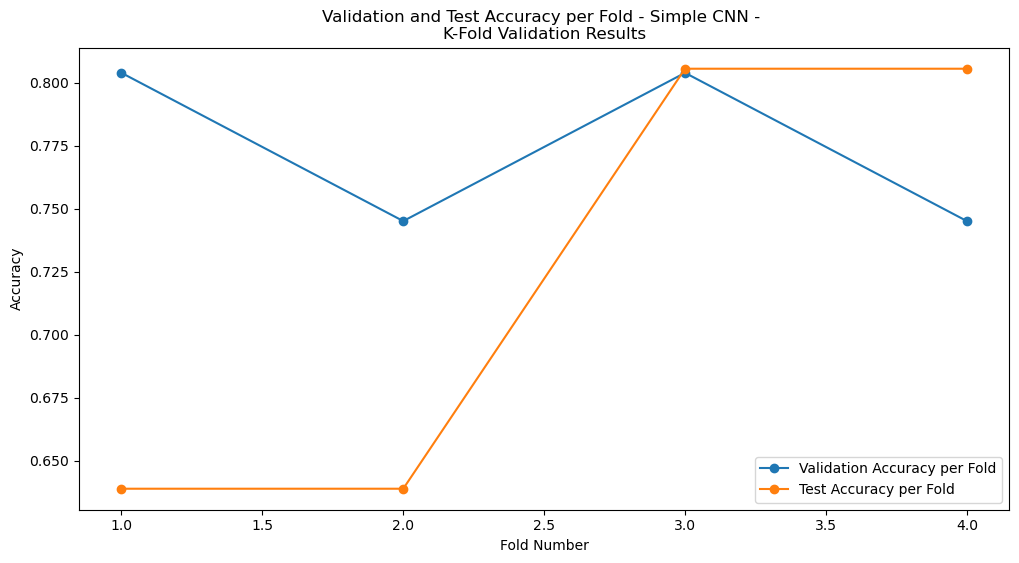


Best Fold (1) Performance:
Test Accuracy: 0.6389, Validation Accuracy: 0.8039


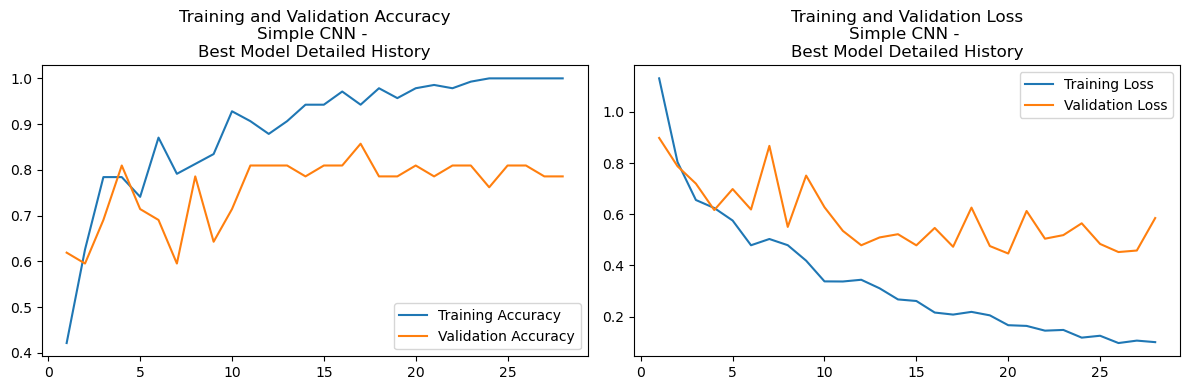

In [24]:
def create_simple_model():
    model = (CNNModel().create_model()
                      .add_conv2d(32)
                      .add_maxpooling2d()
                      .add_flatten()
                      .add_dense())
    return model

simple_cnn_benchmark = (ModelEvaluator(images, labels)
                        .set_params(epochs=30, batch_size=14, learning_rate=2e-5)
                        .perform_kfold_validation(create_simple_model, 'Simple CNN')
                        .plot_results()
                        .get_results_averages())

keras_backend.clear_session()

# 5. Complex CNN Model

Epoch 1/50
10/10 [==============================] - 2s 131ms/step - loss: 1.1215 - accuracy: 0.3571 - val_loss: 1.0738 - val_accuracy: 0.3571
Epoch 2/50
10/10 [==============================] - 1s 109ms/step - loss: 1.0104 - accuracy: 0.5899 - val_loss: 0.9314 - val_accuracy: 0.5476
Epoch 3/50
10/10 [==============================] - 1s 101ms/step - loss: 0.9021 - accuracy: 0.6403 - val_loss: 0.9478 - val_accuracy: 0.6667
Epoch 4/50
10/10 [==============================] - 1s 108ms/step - loss: 0.7941 - accuracy: 0.7122 - val_loss: 0.9054 - val_accuracy: 0.5476
Epoch 5/50
10/10 [==============================] - 1s 110ms/step - loss: 0.7279 - accuracy: 0.7410 - val_loss: 0.6535 - val_accuracy: 0.7857
Epoch 6/50
10/10 [==============================] - 1s 100ms/step - loss: 0.6416 - accuracy: 0.8058 - val_loss: 0.6982 - val_accuracy: 0.8095
Epoch 7/50
10/10 [==============================] - 1s 109ms/step - loss: 0.6129 - accuracy: 0.7410 - val_loss: 0.6287 - val_accuracy: 0.7619
Epoch 

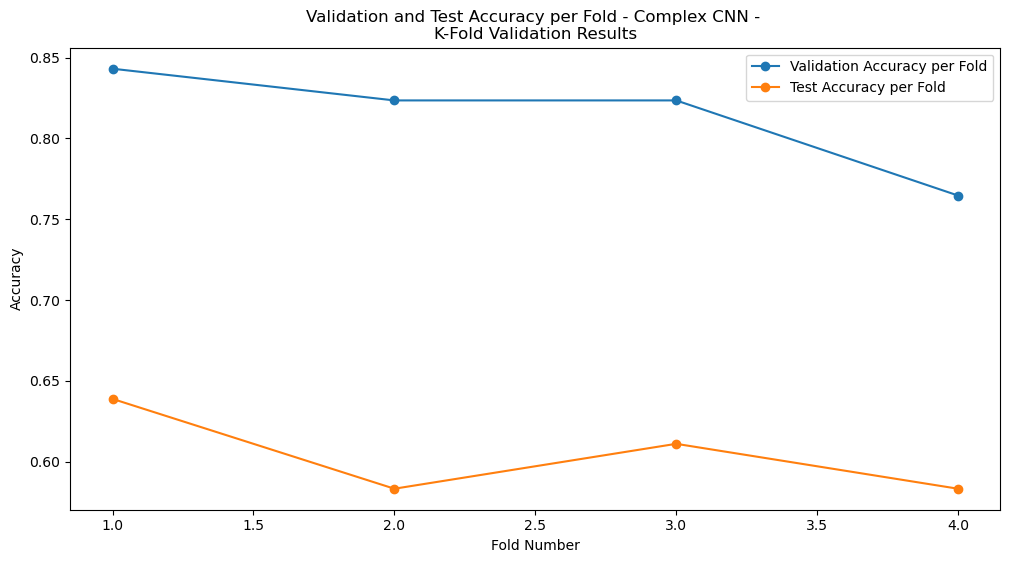


Best Fold (1) Performance:
Test Accuracy: 0.6389, Validation Accuracy: 0.8431


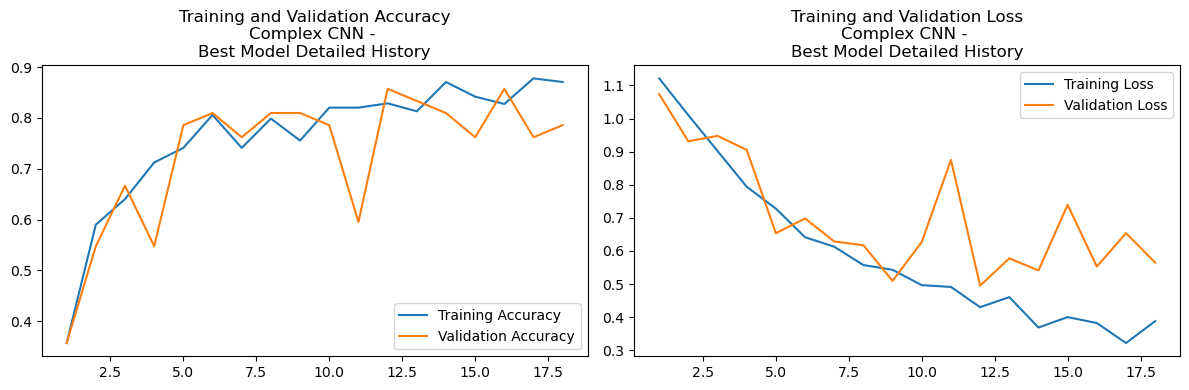

Model Comparison Summary:
- Current Model: Complex CNN
- Benchmark Model: Basic CNN
Average Validation Accuracy: Current Model = 0.8137, Benchmark = 0.7745, Delta = 0.0392
Average Test Accuracy: Current Model = 0.6042, Benchmark = 0.7222, Delta = -0.1181
Average Validation Loss: Current Model = 0.4678, Benchmark = 0.4966, Delta = -0.0288
Average Test Loss: Current Model = 0.7792, Benchmark = 0.6499, Delta = 0.1293
Overall Assessment: The current model does not show significant improvement over the benchmark.


In [38]:
def create_complex_cnn_model():
    model = (CNNModel().create_model()
                      .add_conv2d(64)
                      .add_maxpooling2d()
                      .add_conv2d(128)
                      .add_maxpooling2d()
                      .add_conv2d(256)
                      .add_maxpooling2d()
                      .add_conv2d(512)
                      .add_maxpooling2d() 
                      .add_flatten() 
                      .add_dense(512, activation='relu') 
                      .add_dense(3, activation='softmax'))
    return model

(ModelEvaluator(images, labels)
      .set_params(epochs=50, batch_size=14, learning_rate=2e-5)
      .perform_kfold_validation(create_complex_cnn_model, 'Complex CNN')
      .plot_results()
      .compare_and_summarise_performance(simple_cnn_benchmark)
      .clear_session())

# 5.1 Second Complex CNN Model

Epoch 1/50
10/10 [==============================] - 2s 128ms/step - loss: 1.1642 - accuracy: 0.3714 - val_loss: 0.9585 - val_accuracy: 0.5000
Epoch 2/50
10/10 [==============================] - 1s 104ms/step - loss: 0.9544 - accuracy: 0.4964 - val_loss: 0.9274 - val_accuracy: 0.5476
Epoch 3/50
10/10 [==============================] - 1s 93ms/step - loss: 0.8205 - accuracy: 0.6835 - val_loss: 0.9721 - val_accuracy: 0.5476
Epoch 4/50
10/10 [==============================] - 1s 103ms/step - loss: 0.7820 - accuracy: 0.6619 - val_loss: 0.7519 - val_accuracy: 0.5476
Epoch 5/50
10/10 [==============================] - 1s 103ms/step - loss: 0.6892 - accuracy: 0.6906 - val_loss: 0.7000 - val_accuracy: 0.8095
Epoch 6/50
10/10 [==============================] - 1s 103ms/step - loss: 0.5647 - accuracy: 0.8058 - val_loss: 0.5850 - val_accuracy: 0.7857
Epoch 7/50
10/10 [==============================] - 1s 94ms/step - loss: 0.5598 - accuracy: 0.7698 - val_loss: 0.6246 - val_accuracy: 0.6905
Epoch 8/

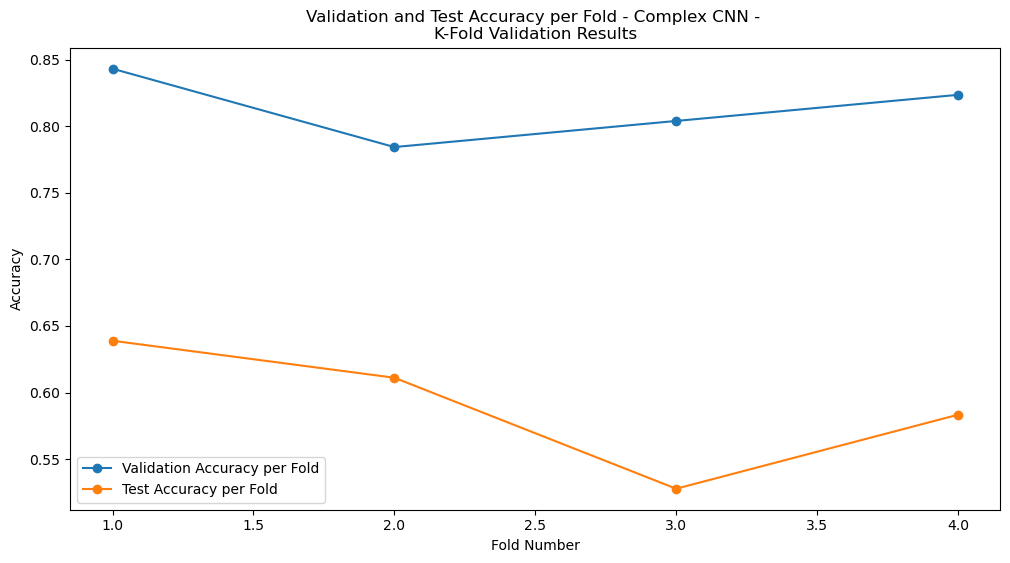


Best Fold (1) Performance:
Test Accuracy: 0.6389, Validation Accuracy: 0.8431


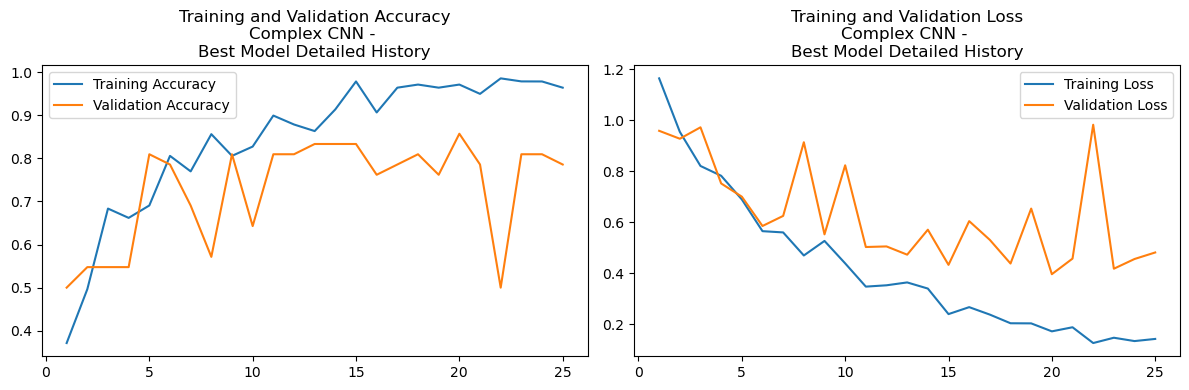

Model Comparison Summary:
- Current Model: Complex CNN
- Benchmark Model: Basic CNN
Average Validation Accuracy: Current Model = 0.8137, Benchmark = 0.7745, Delta = 0.0392
Average Test Accuracy: Current Model = 0.5903, Benchmark = 0.7222, Delta = -0.1319
Average Validation Loss: Current Model = 0.4949, Benchmark = 0.4966, Delta = -0.0017
Average Test Loss: Current Model = 0.7931, Benchmark = 0.6499, Delta = 0.1433
Overall Assessment: The current model does not show significant improvement over the benchmark.


{'avg_val_acc': 0.8137255012989044,
 'avg_val_loss': 0.4949031248688698,
 'avg_test_acc': 0.5902777761220932,
 'avg_test_loss': 0.793125182390213}

In [33]:
def create_complex_cnn_model_2():
    model = (CNNModel().create_model()
                      .add_conv2d(64)
                      .add_maxpooling2d()
                      .add_conv2d(128)
                      .add_maxpooling2d()
                      .add_conv2d(256)
                      .add_maxpooling2d()
                      .add_flatten() 
                      .add_dense(256, activation='relu') 
                      .add_dense(3, activation='softmax'))
    return model

(ModelEvaluator(images, labels)
      .set_params(epochs=50, batch_size=14, learning_rate=2e-5)
      .perform_kfold_validation(create_complex_cnn_model, 'Complex CNN')
      .plot_results()
      .compare_and_summarise_performance(simple_cnn_benchmark)
      .clear_session())

# 5.2 Third Complex CNN Model

Epoch 1/50
10/10 [==============================] - 2s 127ms/step - loss: 1.1191 - accuracy: 0.3786 - val_loss: 0.9156 - val_accuracy: 0.5238
Epoch 2/50
10/10 [==============================] - 1s 103ms/step - loss: 0.8820 - accuracy: 0.5755 - val_loss: 0.7804 - val_accuracy: 0.7143
Epoch 3/50
10/10 [==============================] - 1s 102ms/step - loss: 0.7475 - accuracy: 0.6906 - val_loss: 0.7010 - val_accuracy: 0.8095
Epoch 4/50
10/10 [==============================] - 1s 102ms/step - loss: 0.6023 - accuracy: 0.7698 - val_loss: 0.5990 - val_accuracy: 0.8095
Epoch 5/50
10/10 [==============================] - 1s 92ms/step - loss: 0.4660 - accuracy: 0.8993 - val_loss: 0.8437 - val_accuracy: 0.5952
Epoch 6/50
10/10 [==============================] - 1s 103ms/step - loss: 0.5374 - accuracy: 0.7698 - val_loss: 0.5962 - val_accuracy: 0.7619
Epoch 7/50
10/10 [==============================] - 1s 102ms/step - loss: 0.4750 - accuracy: 0.8273 - val_loss: 0.5064 - val_accuracy: 0.8095
Epoch 8

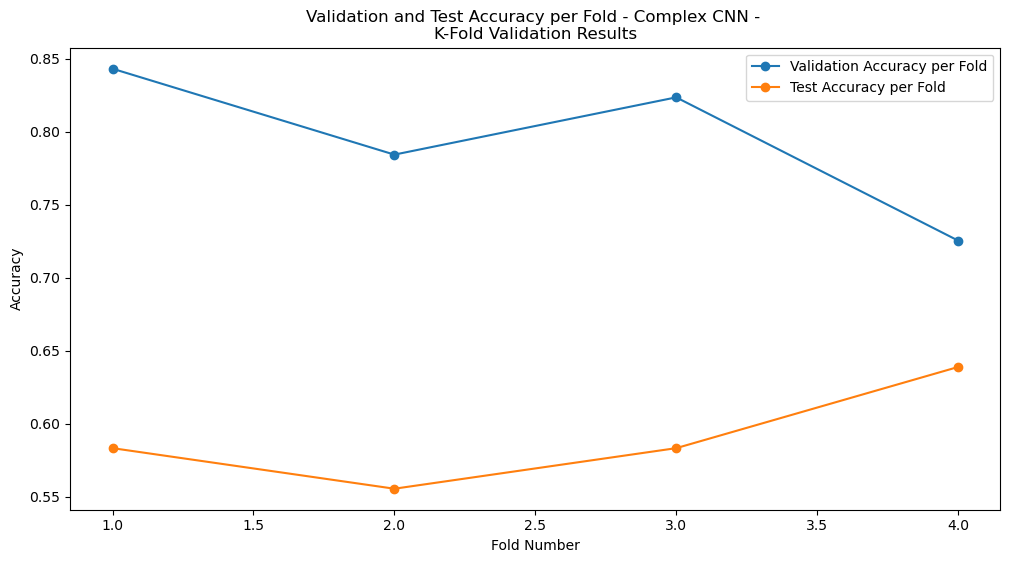


Best Fold (1) Performance:
Test Accuracy: 0.5833, Validation Accuracy: 0.8431


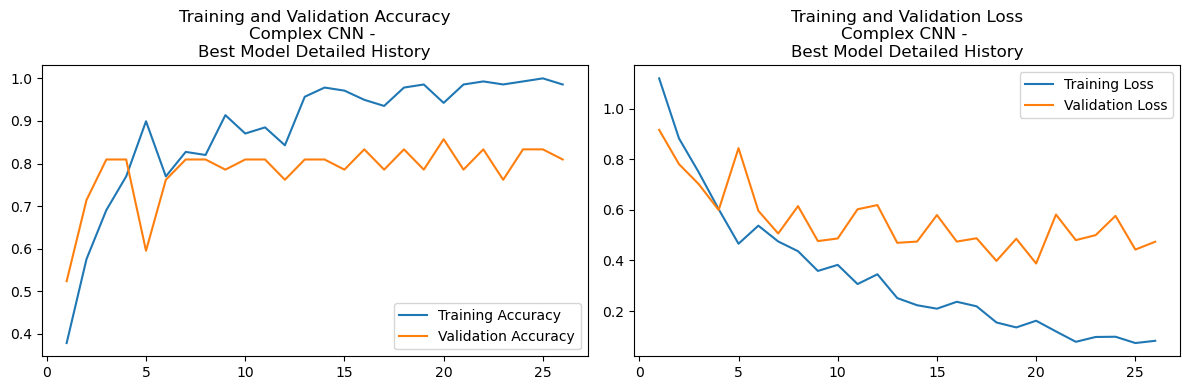

Model Comparison Summary:
- Current Model: Complex CNN
- Benchmark Model: Basic CNN
Average Validation Accuracy: Current Model = 0.7941, Benchmark = 0.7745, Delta = 0.0196
Average Test Accuracy: Current Model = 0.5903, Benchmark = 0.7222, Delta = -0.1319
Average Validation Loss: Current Model = 0.4903, Benchmark = 0.4966, Delta = -0.0062
Average Test Loss: Current Model = 0.7830, Benchmark = 0.6499, Delta = 0.1331
Overall Assessment: The current model does not show significant improvement over the benchmark.


In [37]:
def create_complex_cnn_model_3():
    model = (CNNModel().create_model()
                      .add_conv2d(64)
                      .add_maxpooling2d()
                      .add_conv2d(128)
                      .add_maxpooling2d()
                      .add_flatten() 
                      .add_dense(256, activation='relu') 
                      .add_dense(3, activation='softmax'))
    return model

(ModelEvaluator(images, labels)
      .set_params(epochs=50, batch_size=14, learning_rate=2e-5)
      .perform_kfold_validation(create_complex_cnn_model, 'Complex CNN')
      .plot_results()
      .compare_and_summarise_performance(simple_cnn_benchmark)
      .clear_session())

# 6. Complex CNN model with data augmentation

Epoch 1/100
10/10 [==============================] - 2s 130ms/step - loss: 1.1111 - accuracy: 0.4101 - val_loss: 1.0502 - val_accuracy: 0.4706
Epoch 2/100
10/10 [==============================] - 1s 101ms/step - loss: 1.0734 - accuracy: 0.3885 - val_loss: 1.0853 - val_accuracy: 0.4902
Epoch 3/100
10/10 [==============================] - 1s 109ms/step - loss: 1.0267 - accuracy: 0.5036 - val_loss: 1.0227 - val_accuracy: 0.3725
Epoch 4/100
10/10 [==============================] - 1s 110ms/step - loss: 0.9854 - accuracy: 0.5324 - val_loss: 0.9672 - val_accuracy: 0.4510
Epoch 5/100
10/10 [==============================] - 1s 113ms/step - loss: 0.9077 - accuracy: 0.6259 - val_loss: 0.8592 - val_accuracy: 0.6667
Epoch 6/100
10/10 [==============================] - 1s 101ms/step - loss: 0.8553 - accuracy: 0.6475 - val_loss: 0.9932 - val_accuracy: 0.4510
Epoch 7/100
10/10 [==============================] - 1s 109ms/step - loss: 0.8418 - accuracy: 0.6259 - val_loss: 0.7280 - val_accuracy: 0.7255

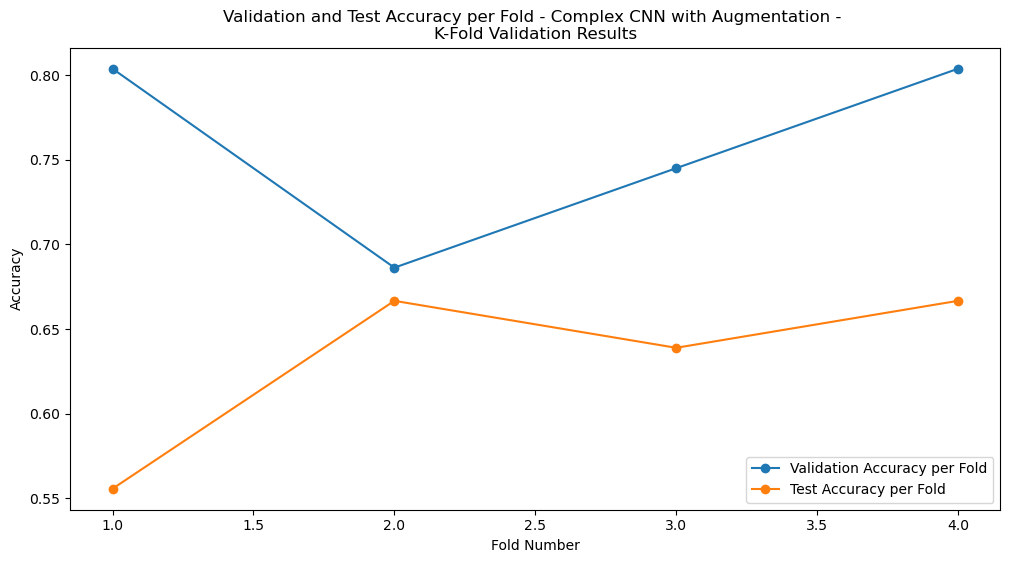


Best Fold (1) Performance:
Test Accuracy: 0.5556, Validation Accuracy: 0.8039


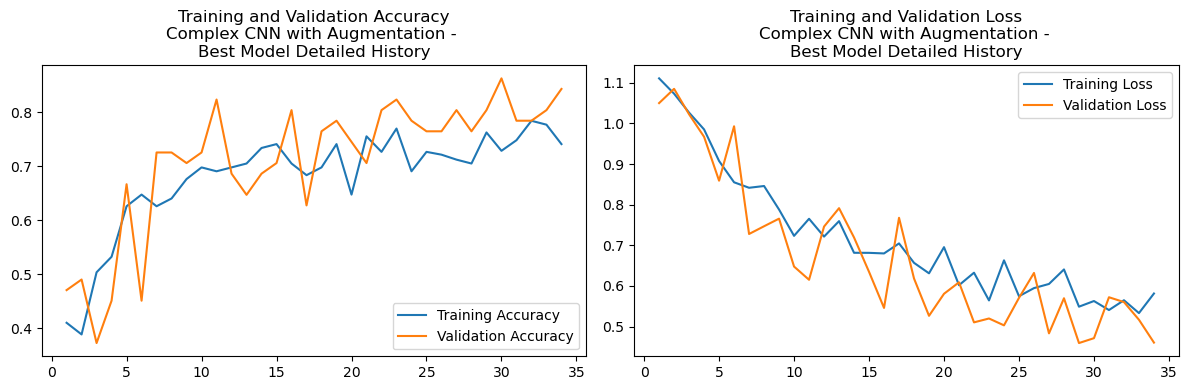

Model Comparison Summary:
- Current Model: Complex CNN with Augmentation
- Benchmark Model: Basic CNN
Average Validation Accuracy: Current Model = 0.7598, Benchmark = 0.7745, Delta = -0.0147
Average Test Accuracy: Current Model = 0.6319, Benchmark = 0.7222, Delta = -0.0903
Average Validation Loss: Current Model = 0.4984, Benchmark = 0.4966, Delta = 0.0018
Average Test Loss: Current Model = 0.6445, Benchmark = 0.6499, Delta = -0.0054
Overall Assessment: The current model does not show significant improvement over the benchmark.


In [30]:
(ModelEvaluator(images, labels)
    .set_params(epochs=100, batch_size=14, learning_rate=2e-5)
    .perform_kfold_validation(create_complex_cnn_model, 'Complex CNN with Augmentation', use_augmentation=True, 
      augment_params={
        'horizontal_flip': True, 
        'rotation_range': 30, 
        'width_shift_range': 0.2, 
        'height_shift_range': 0.2,
        'shear_range': 0.2 
    })
    .select_best_model()
    .plot_results()
    .compare_and_summarise_performance(simple_cnn_benchmark)
    .clear_session())

# 8. CNN model with regularization


Epoch 1/100
10/10 [==============================] - 2s 140ms/step - loss: 2.6759 - accuracy: 0.3857 - val_loss: 2.5913 - val_accuracy: 0.5238
Epoch 2/100
10/10 [==============================] - 1s 113ms/step - loss: 2.5177 - accuracy: 0.5971 - val_loss: 2.4397 - val_accuracy: 0.8095
Epoch 3/100
10/10 [==============================] - 1s 114ms/step - loss: 2.3427 - accuracy: 0.7338 - val_loss: 2.4113 - val_accuracy: 0.5476
Epoch 4/100
10/10 [==============================] - 1s 102ms/step - loss: 2.2053 - accuracy: 0.7410 - val_loss: 2.5366 - val_accuracy: 0.5000
Epoch 5/100
10/10 [==============================] - 1s 112ms/step - loss: 2.1258 - accuracy: 0.7482 - val_loss: 2.0618 - val_accuracy: 0.8571
Epoch 6/100
10/10 [==============================] - 1s 111ms/step - loss: 2.0189 - accuracy: 0.7338 - val_loss: 1.9650 - val_accuracy: 0.8571
Epoch 7/100
10/10 [==============================] - 1s 115ms/step - loss: 1.9378 - accuracy: 0.7914 - val_loss: 1.8709 - val_accuracy: 0.7619

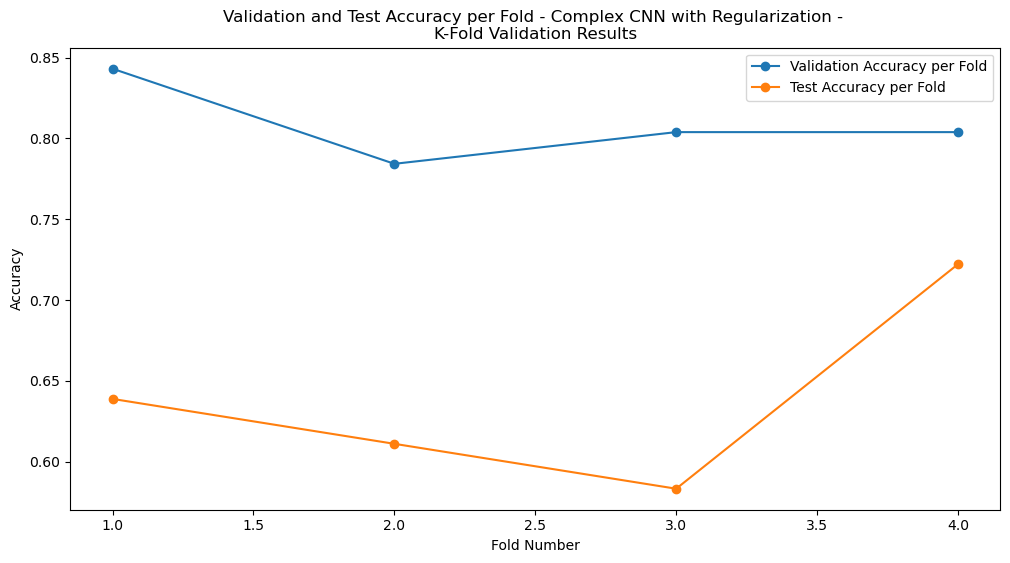


Best Fold (1) Performance:
Test Accuracy: 0.6389, Validation Accuracy: 0.8431


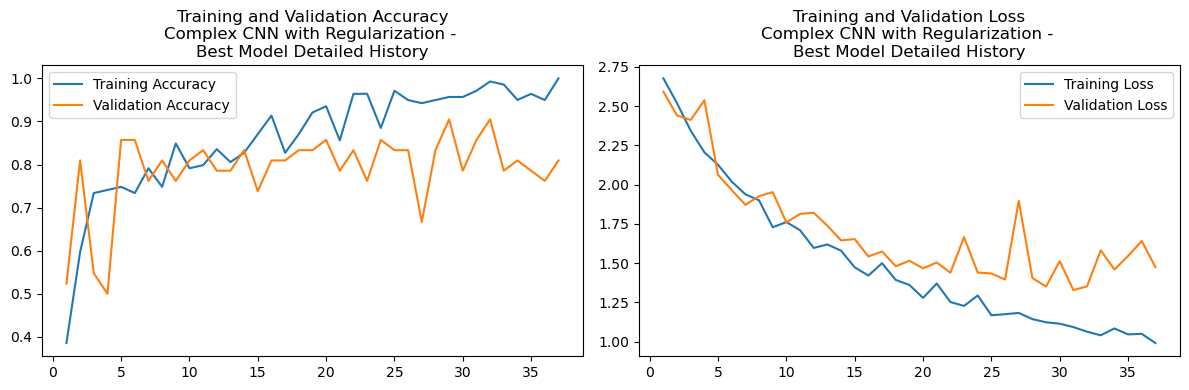

Model Comparison Summary:
- Current Model: Complex CNN with Regularization
- Benchmark Model: Basic CNN
Average Validation Accuracy: Current Model = 0.8088, Benchmark = 0.7745, Delta = 0.0343
Average Test Accuracy: Current Model = 0.6389, Benchmark = 0.7222, Delta = -0.0833
Average Validation Loss: Current Model = 1.3924, Benchmark = 0.4966, Delta = 0.8958
Average Test Loss: Current Model = 1.6516, Benchmark = 0.6499, Delta = 1.0017
Overall Assessment: The current model does not show significant improvement over the benchmark.


In [47]:
def create_complex_cnn_model_wr():
    model = (CNNModel().create_model()
                      .add_conv2d(64, regularizer=l2(1e-3))
                      .add_maxpooling2d()
                      .add_conv2d(128, regularizer=l2(1e-3))
                      .add_maxpooling2d()
                      .add_conv2d(256, regularizer=l2(1e-3)) 
                      .add_maxpooling2d()
                      .add_conv2d(512, regularizer=l2(1e-3))   
                      .add_maxpooling2d()
                      .add_flatten() 
                      .add_dense(512, activation='relu', regularizer=l2(1e-3)) 
                      .add_dense(3, activation='softmax', regularizer=l2(1e-3)))
    return model


(ModelEvaluator(images, labels)
    .set_params(epochs=100, batch_size=14, learning_rate=2e-5)
    .perform_kfold_validation(create_complex_cnn_model_wr, 'Complex CNN with Regularisation')
    .select_best_model()
    .plot_results()
    .compare_and_summarise_performance(simple_cnn_benchmark)
    .clear_session())

# 7. CNN model with dropout

Epoch 1/100
10/10 [==============================] - 2s 149ms/step - loss: 1.0862 - accuracy: 0.4143 - val_loss: 1.0769 - val_accuracy: 0.5000
Epoch 2/100
10/10 [==============================] - 1s 111ms/step - loss: 1.0157 - accuracy: 0.5252 - val_loss: 0.9797 - val_accuracy: 0.5952
Epoch 3/100
10/10 [==============================] - 1s 108ms/step - loss: 0.9275 - accuracy: 0.6115 - val_loss: 0.8904 - val_accuracy: 0.8095
Epoch 4/100
10/10 [==============================] - 1s 107ms/step - loss: 0.8516 - accuracy: 0.7122 - val_loss: 0.7735 - val_accuracy: 0.7619
Epoch 5/100
10/10 [==============================] - 1s 107ms/step - loss: 0.7354 - accuracy: 0.7122 - val_loss: 0.7394 - val_accuracy: 0.7857
Epoch 6/100
10/10 [==============================] - 1s 99ms/step - loss: 0.6935 - accuracy: 0.7194 - val_loss: 0.8351 - val_accuracy: 0.5952
Epoch 7/100
10/10 [==============================] - 1s 108ms/step - loss: 0.6580 - accuracy: 0.7554 - val_loss: 0.6668 - val_accuracy: 0.8333


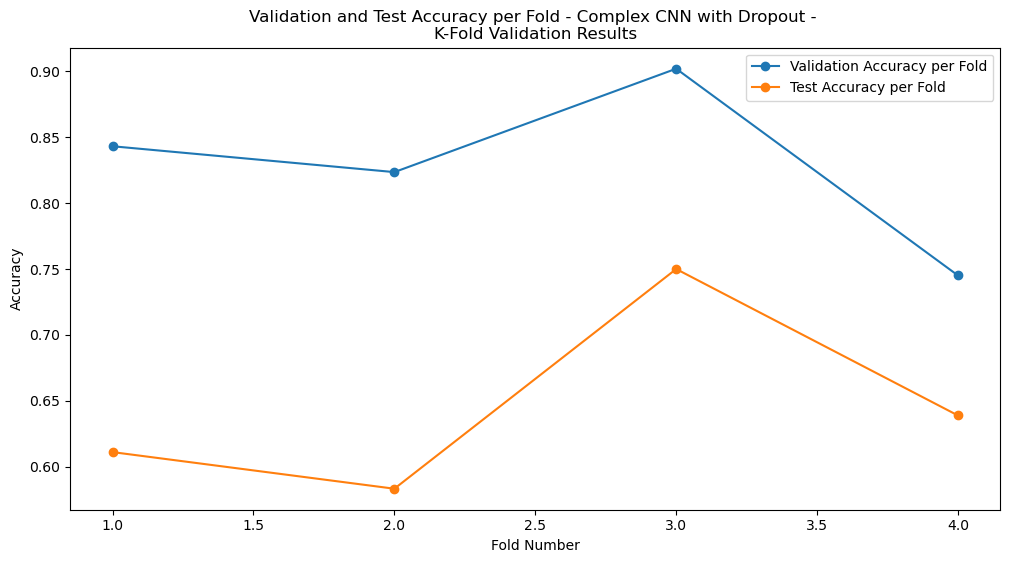


Best Fold (3) Performance:
Test Accuracy: 0.7500, Validation Accuracy: 0.9020


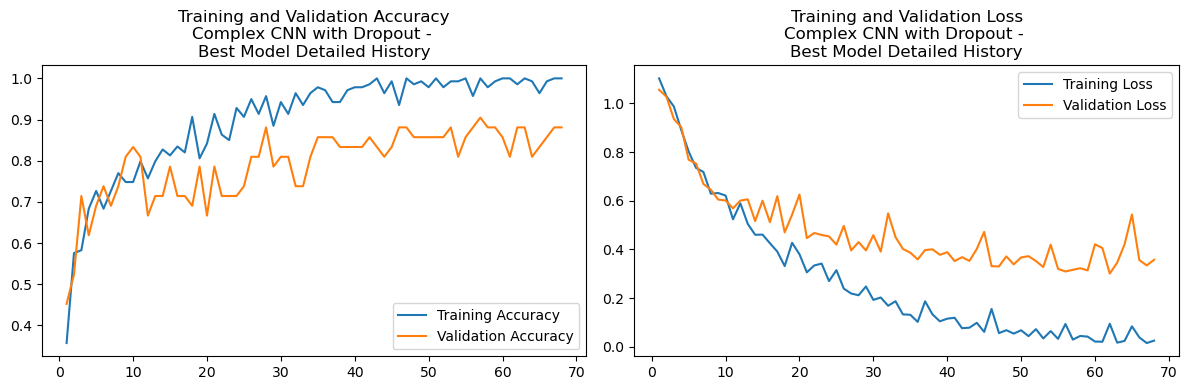

Model Comparison Summary:
- Current Model: Complex CNN with Dropout
- Benchmark Model: Basic CNN
Average Validation Accuracy: Current Model = 0.8284, Benchmark = 0.7745, Delta = 0.0539
Average Test Accuracy: Current Model = 0.6458, Benchmark = 0.7222, Delta = -0.0764
Average Validation Loss: Current Model = 0.4315, Benchmark = 0.4966, Delta = -0.0651
Average Test Loss: Current Model = 0.7889, Benchmark = 0.6499, Delta = 0.1391
Overall Assessment: The current model does not show significant improvement over the benchmark.


In [49]:

def create_complex_cnn_model_dr():
    model = (CNNModel().create_model()
                      .add_conv2d(64)
                      .add_maxpooling2d()
                      .add_conv2d(128)
                      .add_maxpooling2d()
                      .add_conv2d(256) 
                      .add_maxpooling2d()
                      .add_conv2d(512)   
                      .add_maxpooling2d()
                      .add_flatten() 
                      .add_dense(512, activation='relu')
                      .add_dropout(0.5)
                      .add_dense(3, activation='softmax'))
    return model

(ModelEvaluator(images, labels)
    .set_params(epochs=100, batch_size=14, learning_rate=2e-5)
    .perform_kfold_validation(create_complex_cnn_model_dr, 'Complex CNN with Dropout')
    .plot_results()
    .compare_and_summarise_performance(simple_cnn_benchmark)
    .clear_session())



# 8. Combination of all techniques

Epoch 1/100
10/10 [==============================] - 2s 164ms/step - loss: 2.6988 - accuracy: 0.3071 - val_loss: 2.6039 - val_accuracy: 0.4314
Epoch 2/100
10/10 [==============================] - 1s 117ms/step - loss: 2.5788 - accuracy: 0.4532 - val_loss: 2.5992 - val_accuracy: 0.2941
Epoch 3/100
10/10 [==============================] - 1s 116ms/step - loss: 2.5302 - accuracy: 0.4748 - val_loss: 2.4406 - val_accuracy: 0.6078
Epoch 4/100
10/10 [==============================] - 1s 114ms/step - loss: 2.4306 - accuracy: 0.5468 - val_loss: 2.3696 - val_accuracy: 0.6078
Epoch 5/100
10/10 [==============================] - 1s 117ms/step - loss: 2.3498 - accuracy: 0.5899 - val_loss: 2.3201 - val_accuracy: 0.5686
Epoch 6/100
10/10 [==============================] - 1s 114ms/step - loss: 2.2816 - accuracy: 0.5827 - val_loss: 2.2052 - val_accuracy: 0.6471
Epoch 7/100
10/10 [==============================] - 1s 105ms/step - loss: 2.2298 - accuracy: 0.6043 - val_loss: 2.2418 - val_accuracy: 0.5294

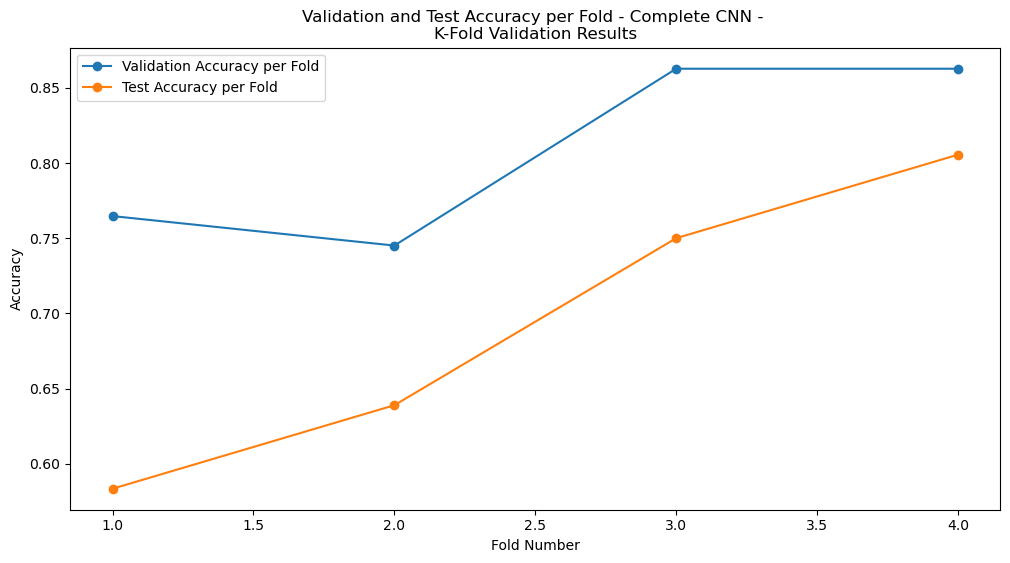


Best Fold (3) Performance:
Test Accuracy: 0.7500, Validation Accuracy: 0.8627


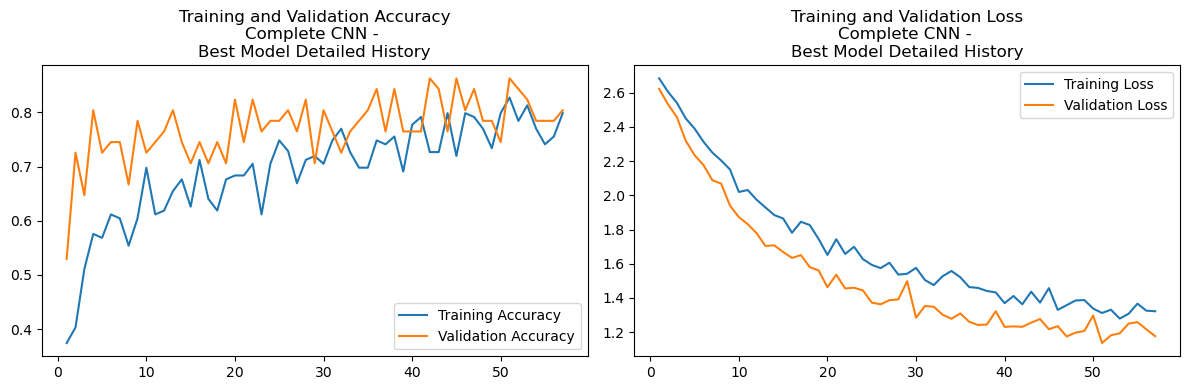

Model Comparison Summary:
- Current Model: Complete CNN
- Benchmark Model: Basic CNN
Average Validation Accuracy: Current Model = 0.8088, Benchmark = 0.7745, Delta = 0.0343
Average Test Accuracy: Current Model = 0.6944, Benchmark = 0.7222, Delta = -0.0278
Average Validation Loss: Current Model = 1.2164, Benchmark = 0.4966, Delta = 0.7198
Average Test Loss: Current Model = 1.3375, Benchmark = 0.6499, Delta = 0.6876
Overall Assessment: The current model does not show significant improvement over the benchmark.


In [50]:
def create_complete_cnn_model():
    model = (CNNModel().create_model()
                      .add_conv2d(64, regularizer=l2(1e-3))
                      .add_maxpooling2d()
                      .add_conv2d(128, regularizer=l2(1e-3))
                      .add_maxpooling2d()
                      .add_conv2d(256, regularizer=l2(1e-3)) 
                      .add_maxpooling2d()
                      .add_conv2d(512, regularizer=l2(1e-3))   
                      .add_maxpooling2d()
                      .add_flatten() 
                      .add_dense(512, activation='relu', regularizer=l2(1e-3)) 
                      .add_dropout(0.5)
                      .add_dense(3, activation='softmax', regularizer=l2(1e-3)))
    return model

(ModelEvaluator(images, labels)
    .set_params(epochs=100, batch_size=14, learning_rate=2e-5)
    .perform_kfold_validation(create_complete_cnn_model, 'Complete CNN', use_augmentation=True, 
      augment_params={
        'horizontal_flip': True, 
        'rotation_range': 30, 
        'width_shift_range': 0.2, 
        'height_shift_range': 0.2,
        'shear_range': 0.2 
    })
    .plot_results()
    .compare_and_summarise_performance(simple_cnn_benchmark)
    .clear_session())

# 9. Hyperparameter tuning

Testing with parameters: {'epochs': 30, 'batch_size': 7, 'learning_rate': 2e-05, 'dropout_rate': 0.25, 'l2_rate': 0.001}
Epoch 1/30
24/24 [==============================] - 2s 80ms/step - loss: 2.6409 - accuracy: 0.4048 - val_loss: 2.5478 - val_accuracy: 0.4722
Epoch 2/30
24/24 [==============================] - 2s 69ms/step - loss: 2.4224 - accuracy: 0.5357 - val_loss: 2.3901 - val_accuracy: 0.5000
Epoch 3/30
24/24 [==============================] - 2s 69ms/step - loss: 2.2762 - accuracy: 0.5417 - val_loss: 2.3468 - val_accuracy: 0.5000
Epoch 4/30
24/24 [==============================] - 2s 69ms/step - loss: 2.1049 - accuracy: 0.6429 - val_loss: 2.2515 - val_accuracy: 0.5833
Epoch 5/30
24/24 [==============================] - 2s 65ms/step - loss: 1.9195 - accuracy: 0.7024 - val_loss: 2.4107 - val_accuracy: 0.5000
Epoch 6/30
24/24 [==============================] - 2s 69ms/step - loss: 1.8781 - accuracy: 0.6607 - val_loss: 1.9984 - val_accuracy: 0.5833
Epoch 7/30
24/24 [===============

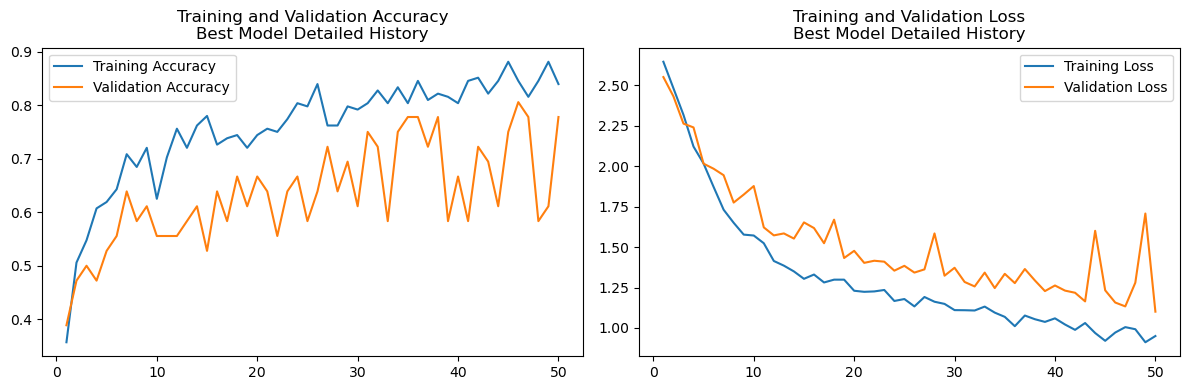

In [62]:
hyperparams = {
    'epochs': [30, 50],
    'batch_size': [7, 14, 28],
    'learning_rate': [2e-5, 1e-5],
    'dropout_rate' : [ 0.25, 0.5],
    'l2_rate': [1e-3, 1e-4]
}


def use_complete_cnn_model(dropout_rate, l2_rate):
    model = (CNNModel().create_model()
                      .add_conv2d(64, regularizer=l2(l2_rate))
                      .add_maxpooling2d()
                      .add_conv2d(128, regularizer=l2(l2_rate))
                      .add_maxpooling2d()
                      .add_conv2d(256, regularizer=l2(l2_rate)) 
                      .add_maxpooling2d()
                      .add_conv2d(512, regularizer=l2(l2_rate))   
                      .add_maxpooling2d()
                      .add_flatten() 
                      .add_dense(512, activation='relu', regularizer=l2(l2_rate)) 
                      .add_dropout(dropout_rate)
                      .add_dense(3, activation='softmax', regularizer=l2(l2_rate)))
    return model

(ModelEvaluator(images, labels)
    .test_hyperparameters(use_complete_cnn_model, 'Complete CNN', hyperparams, use_augmentation=True, 
      augment_params={
        'horizontal_flip': True, 
        'rotation_range': 30, 
        'width_shift_range': 0.2, 
        'height_shift_range': 0.2,
        'shear_range': 0.2 
    })
    .report_best_hyperparam_results()
    .clear_session())

# 10. Complex CNN with hyperparameters adjusted - k-fold validation

Epoch 1/50
21/21 [==============================] - 2s 83ms/step - loss: 2.6592 - accuracy: 0.3630 - val_loss: 2.5902 - val_accuracy: 0.3137
Epoch 2/50
21/21 [==============================] - 2s 70ms/step - loss: 2.5175 - accuracy: 0.4286 - val_loss: 2.4365 - val_accuracy: 0.5490
Epoch 3/50
21/21 [==============================] - 2s 70ms/step - loss: 2.4176 - accuracy: 0.4384 - val_loss: 2.3664 - val_accuracy: 0.3333
Epoch 4/50
21/21 [==============================] - 2s 70ms/step - loss: 2.3201 - accuracy: 0.4452 - val_loss: 2.1850 - val_accuracy: 0.7059
Epoch 5/50
21/21 [==============================] - 2s 70ms/step - loss: 2.1790 - accuracy: 0.5137 - val_loss: 2.0554 - val_accuracy: 0.7255
Epoch 6/50
21/21 [==============================] - 1s 66ms/step - loss: 2.0404 - accuracy: 0.6575 - val_loss: 2.1008 - val_accuracy: 0.4314
Epoch 7/50
21/21 [==============================] - 2s 70ms/step - loss: 1.9910 - accuracy: 0.5548 - val_loss: 1.8702 - val_accuracy: 0.7255
Epoch 8/50
21

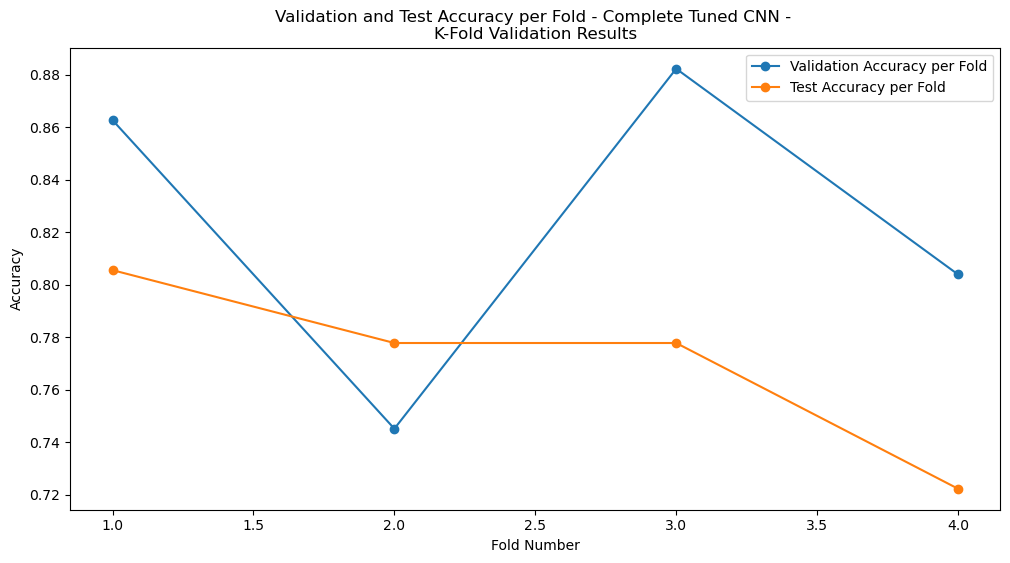


Best Fold (3) Performance:
Test Accuracy: 0.7778, Validation Accuracy: 0.8824


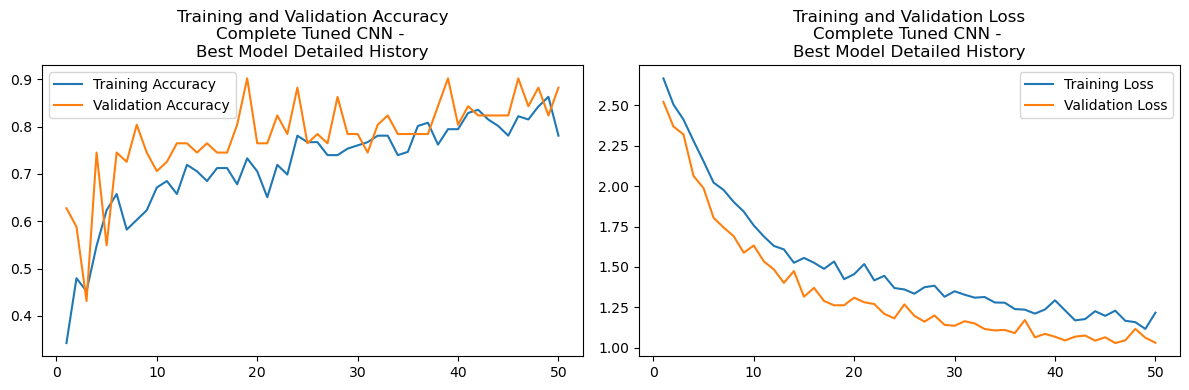

Model Comparison Summary:
- Current Model: Complete Tuned CNN
- Benchmark Model: Basic CNN
Average Validation Accuracy: Current Model = 0.8235, Benchmark = 0.7745, Delta = 0.0490
Average Test Accuracy: Current Model = 0.7708, Benchmark = 0.7222, Delta = 0.0486
Average Validation Loss: Current Model = 1.1157, Benchmark = 0.4966, Delta = 0.6191
Average Test Loss: Current Model = 1.1860, Benchmark = 0.6499, Delta = 0.5362
Overall Assessment: The current model shows improvement over the benchmark.


In [64]:
def create_complete_cnn_tuned_model():
    model = (CNNModel().create_model()
                      .add_conv2d(64, regularizer=l2(1e-3))
                      .add_maxpooling2d()
                      .add_conv2d(128, regularizer=l2(1e-3))
                      .add_maxpooling2d()
                      .add_conv2d(256, regularizer=l2(1e-3)) 
                      .add_maxpooling2d()
                      .add_conv2d(512, regularizer=l2(1e-3))   
                      .add_maxpooling2d()
                      .add_flatten() 
                      .add_dense(512, activation='relu', regularizer=l2(1e-3)) 
                      .add_dropout(0.25)
                      .add_dense(3, activation='softmax', regularizer=l2(1e-3)))
    return model

(ModelEvaluator(images, labels)
    .set_params(epochs=50, batch_size=7, learning_rate=2e-5)
    .perform_kfold_validation(create_complete_cnn_model, 'Complete Tuned CNN', use_augmentation=True, 
      augment_params={
        'horizontal_flip': True, 
        'rotation_range': 30, 
        'width_shift_range': 0.2, 
        'height_shift_range': 0.2,
        'shear_range': 0.2 
    })
    .plot_results()
    .compare_and_summarise_performance(simple_cnn_benchmark)
    .clear_session())



# 8. VGG16 model

Epoch 1/50
21/21 [==============================] - 7s 261ms/step - loss: 1.7963 - accuracy: 0.6301 - val_loss: 1.3159 - val_accuracy: 0.8431
Epoch 2/50
21/21 [==============================] - 1s 60ms/step - loss: 1.3495 - accuracy: 0.8836 - val_loss: 1.1664 - val_accuracy: 0.9216
Epoch 3/50
21/21 [==============================] - 1s 62ms/step - loss: 1.1916 - accuracy: 0.9315 - val_loss: 0.9966 - val_accuracy: 0.9804
Epoch 4/50
21/21 [==============================] - 1s 61ms/step - loss: 1.1239 - accuracy: 0.9178 - val_loss: 0.9557 - val_accuracy: 0.9804
Epoch 5/50
21/21 [==============================] - 1s 61ms/step - loss: 1.0652 - accuracy: 0.9589 - val_loss: 0.9192 - val_accuracy: 0.9804
Epoch 6/50
21/21 [==============================] - 1s 60ms/step - loss: 0.9712 - accuracy: 0.9521 - val_loss: 0.9114 - val_accuracy: 0.9804
Epoch 7/50
21/21 [==============================] - 1s 60ms/step - loss: 0.9491 - accuracy: 0.9521 - val_loss: 0.8979 - val_accuracy: 0.9412
Epoch 8/50
2

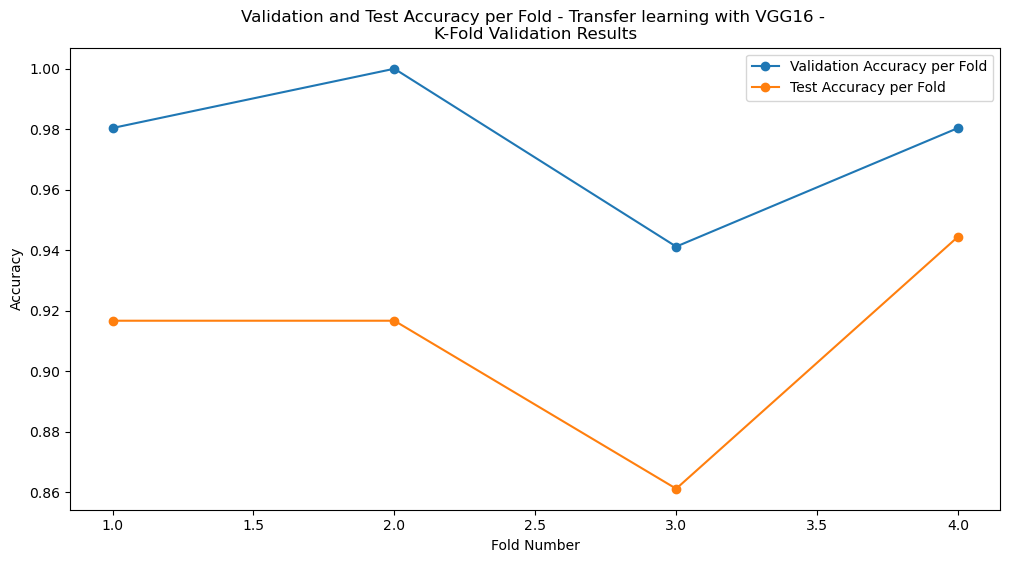


Best Fold (2) Performance:
Test Accuracy: 0.9167, Validation Accuracy: 1.0000


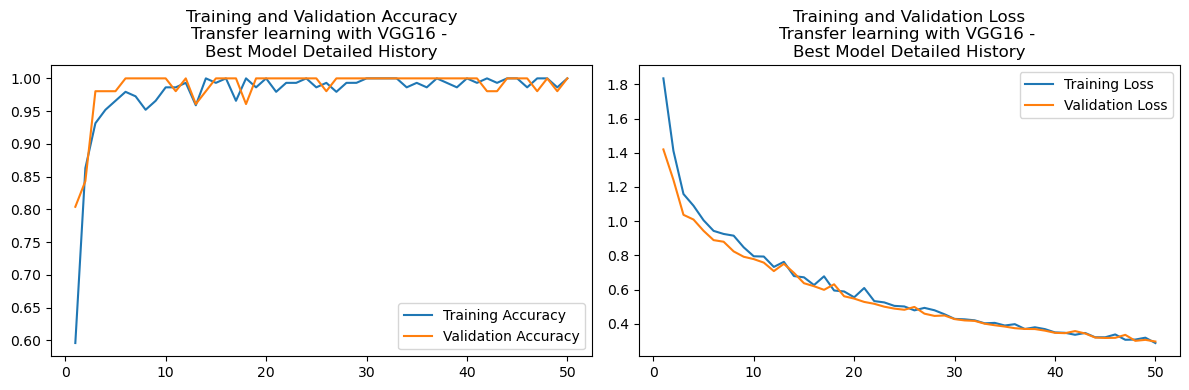

Model Comparison Summary:
- Current Model: Transfer learning with VGG16
- Benchmark Model: Basic CNN
Average Validation Accuracy: Current Model = 0.9755, Benchmark = 0.7745, Delta = 0.2010
Average Test Accuracy: Current Model = 0.9097, Benchmark = 0.7222, Delta = 0.1875
Average Validation Loss: Current Model = 0.3471, Benchmark = 0.4966, Delta = -0.1495
Average Test Loss: Current Model = 0.6014, Benchmark = 0.6499, Delta = -0.0484
Overall Assessment: The current model shows improvement over the benchmark.


In [65]:
def use_vgg16_model():
    vgg16_model = CNNModel().create_model(model_type='vgg16', input_shape=(256, 256, 3)) \
                            .add_flatten() \
                            .add_dense(512, activation='relu', regularizer=l2(1e-3)) \
                            .add_dropout(0.25)\
                            .add_dense(3, activation='softmax', regularizer=l2(1e-3))

   
    return vgg16_model

(ModelEvaluator(images, labels)
    .set_params(epochs=50, batch_size=7, learning_rate=2e-5)
    .perform_kfold_validation(use_vgg16_model, 'Transfer learning with VGG16', use_augmentation=True, 
      augment_params={
        'horizontal_flip': True, 
        'rotation_range': 30, 
        'width_shift_range': 0.2, 
        'height_shift_range': 0.2,
        'shear_range': 0.2 
    })
    .plot_results()
    .compare_and_summarise_performance(simple_cnn_benchmark)
    .clear_session())


# 9. Inception module
This model is based on the Inception module from the paper [Going Deeper with Convolutions](https://arxiv.org/abs/1409.4842) by Szegedy et al. (2014). It is a CNN architecture that uses a combination of convolutional layers of different sizes to capture features at different scales. The model is implemented using the functional API of Keras. Despite of many attempts, this model simply fails to run due to computational limitations of my machine. 


In [1]:
def create_inception_model():
    model = (CNNModel().create_model(model_type='functional', input_shape=(256, 256, 3))
                      .add_inception_module([32, 64, 32])
                      .add_flatten()
                      .add_dense(512, activation='relu', regularizer=l2(1e-3))
                      .add_dropout(0.25)
                      .add_dense(3, activation='softmax', regularizer=l2(1e-3)))
    return model

(ModelEvaluator(images, labels)
    .set_params(epochs=50, batch_size=7, learning_rate=2e-5)
    .perform_kfold_validation(create_inception_model, 'Inception Module', use_augmentation=True, 
      augment_params={
        'horizontal_flip': True, 
        'rotation_range': 30, 
        'width_shift_range': 0.2, 
        'height_shift_range': 0.2,
        'shear_range': 0.2 
    })
    .plot_results()
    .compare_and_summarise_performance(simple_cnn_benchmark)
    .clear_session())



NameError: name 'ModelEvaluator' is not defined